# NDVI-based approach to study Landslide areas

Research indicates that NDVI can play a crucial role in identifying landslide zones. While an advanced workflow is possible, this notebook opts for a simple approach using the difference of NDVI and applying a threshold to the result to detect landslide occurred areas. Our analysis relies on the Sentinel-2 Level 2A collection fetched from the Copernicus Data Space Ecosystem using openEO.


In [1]:
import openeo
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Here, we do the test for [Ischia in Italy](https://en.wikipedia.org/wiki/2022_Ischia_landslide) for the fall of 2022, where several landsides were registered.

In [3]:
spatial_extent = {
    "west": 13.882567409197492,
    "south": 40.7150627793427,
    "east": 13.928593792166282,
    "north": 40.747050251559216,
}

Let us load pre Sentinel2 collection

In [4]:
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-08-25", "2022-11-25"],
    spatial_extent=spatial_extent,
    bands=["B04", "B08"],
)

Now, let's calculate pre-NDVI and take a mean over the temporal extent.

In [5]:
prendvi = s2pre.ndvi().mean_time()

For the post datacube, let's load the Sentinel2 collection with the temporal extent starting from the end of the pre-event temporal extent.

In [6]:
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2022-11-26", "2022-12-25"],
    spatial_extent=spatial_extent,
    bands=["B04", "B08"],
)

In [7]:
# calculate post NDVI and take a mean over temporal extent
postndvi = s2post.ndvi().mean_time()

In [8]:
# calculate difference in NDVI
diff = postndvi - prendvi

In [10]:
# lets execute the process
diff.download("NDVIDiff.tiff")

### Plot the result

In [11]:
# load the calculated data
img = rasterio.open("NDVIDiff.tiff")

To better visualise the output, we apply a threshold to define landslide areas.

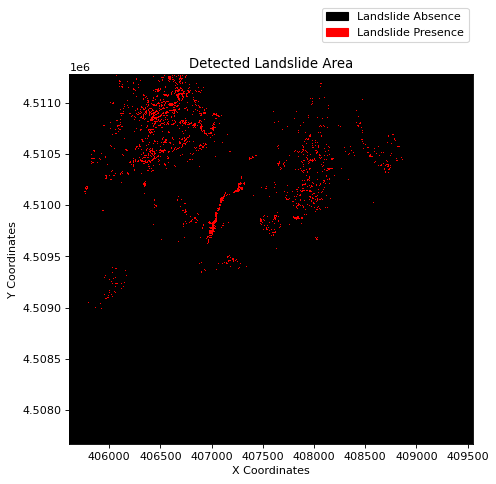

In [12]:
value = img.read(1)
cmap = matplotlib.colors.ListedColormap(["black", "red"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
im = show(
    ((value < -0.48) & (value > -1)),
    vmin=0,
    vmax=1,
    cmap=cmap,
    transform=img.transform,
    ax=ax,
)
values = ["Absence", "Presence"]
colors = ["black", "red"]
ax.set_title("Detected Landslide Area")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
patches = [
    mpatches.Patch(color=colors[i], label="Landslide {l}".format(l=values[i]))
    for i in range(len(values))
]
fig.legend(handles=patches, bbox_to_anchor=(0.83, 1.03), loc=1)

A general observation drawn from the aforementioned result is that the red regions indicate potential landslide activity or vegetation loss.

The red region corresponds to an area where notably large landslides were recorded. However, some false positives can also be noticed in the northwest—an urban area, though not many landslides were reported in those regions. Hence, it is conceivable that there is a change in NDVI, but it might be due to many factors, such as cloud cover, harvesting, vegetation loss, etc. This shows that the difference in the NDVI approach is suitable for rapid mapping but can also contain a lot of misclassified pixels and needs further validation.

#### When comparing the result with the ground truth, it resembles a few landslides that were reported and as shown [in this Wikipedia resource.](https://en.wikipedia.org/wiki/2022_Ischia_landslide#/media/File:2022_Ischia_landslide_-_Copernicus_EMSR643.jpg) 

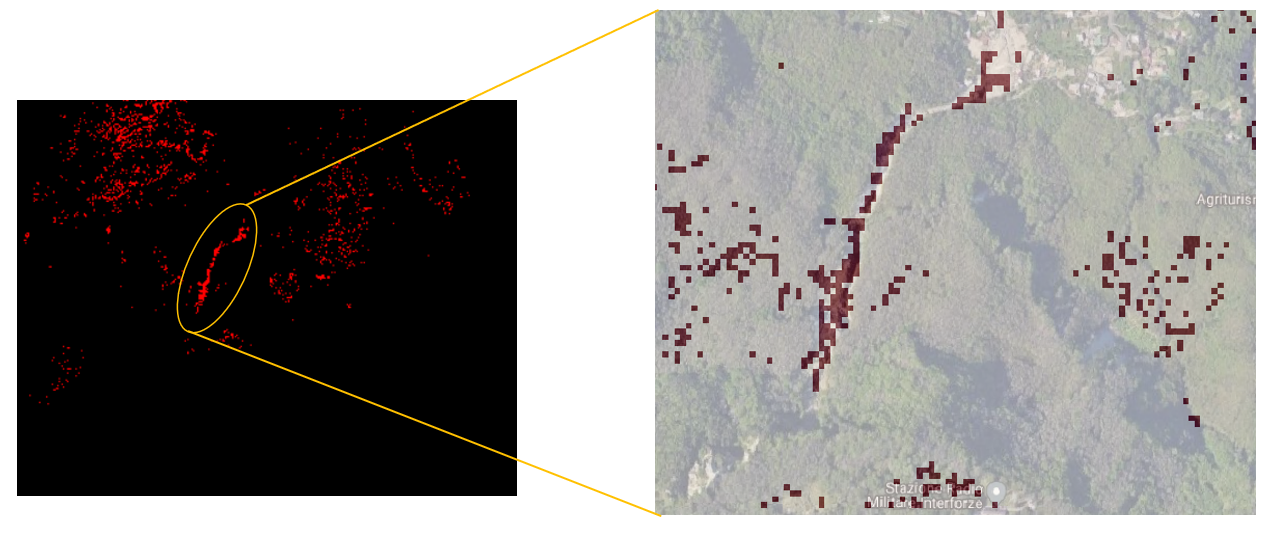